In [60]:
# dependencies
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import sys
import numpy as np
import pandas as pd
import os.path
import Utils.yolo_utils as yolo
import Utils.Plate_Detection as plteD
#import Utils.ImageEnhancementV1 as ImgEn
import Utils.ImageEnhancementV2 as ImgEn
import Utils.TemplateMatching as tm

%matplotlib inline

In [61]:
#pip install opencv-contrib-python 

In [62]:
use_haze_removal = False
detect_truck_plate_brand = False

In [63]:
input_file_name = "Bosch_urn-uuid-00075faa-12bd-bd12-aa5f-0700075faa5f_2019-11-20_12-11-52(1).mp4" #Holiday Video wenesday 11/20/2019 !!!!!!!!!!!!

input_directory_path= '../Dataset/EGYPTE-PUBLIC/ChallengeNumber2/'

full_truck_out_directory_path = "Cropped_Images/"

output_video_directory = "Output_Video/"

weights_directory = "Weights/"

Truck_labels = [name for name in os.listdir("Cropped_ClassifiedTruckType/")]

file_input_path = input_directory_path+input_file_name

print(file_input_path)

../Dataset/EGYPTE-PUBLIC/ChallengeNumber2/Bosch_urn-uuid-00075faa-12bd-bd12-aa5f-0700075faa5f_2019-11-20_12-11-52(1).mp4


In [64]:
#image = mpimg.imread(file_input_path)

inpWidth = 608  #608     #Width of network's input image
inpHeight = 608 #608     #Height of network's input image


In [65]:
w_size=15
a_omega=0.95
gf_w_size=200
eps=1e-6

In [66]:
#cv.imread(("Cropped_ClassifiedTruckType/DAF/134_yolo_out.jpg"))

True


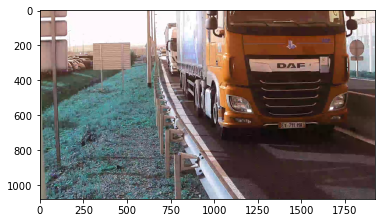

In [67]:
# Open the input file
vid_cap = cv.VideoCapture(file_input_path)
success, image = vid_cap.read()

print(success)


plt.imshow(image)

In [68]:
def resize_image(image, scale_percent=50):
    scale_percent = 30 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_fram = cv.resize(image, dim, interpolation = cv.INTER_AREA) 
    return resized_fram

In [69]:
print(image.shape)

resize_frame = False

image = resize_image(image, scale_percent=50)
print(image.shape)

(1080, 1920, 3)
(324, 576, 3)


In [70]:
# Load names of classes
labels_file = "darknet/data/coco.names"

In [71]:
labels = None
with open(labels_file, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')

In [72]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "darknet/cfg/yolov3.cfg";
modelWeights = "Weights/yolov3.weights";

In [73]:
templates_directory = "TruckTypeDataset/Train"
brand_template_images = tm.get_filepaths(templates_directory)


In [74]:
from keras.models import load_model

digits_char_model = load_model(weights_directory+"adam_OCR_Plate_Model.h5")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [75]:
from sklearn.preprocessing import LabelEncoder


OCR_labels = LabelEncoder()
OCR_labels.classes_ = np.load(weights_directory+'license_character_classes.npy')

In [76]:
from keras.models import load_model

brand_model = load_model(weights_directory+"adam_TruckBrand_Model_FullTruck.h5")

Truck_labels = [name for name in os.listdir("Cropped_ClassifiedTruckType/")]
print(Truck_labels)


['RENO', 'DAF', 'MAN', 'Fox', 'FORD', 'VOLVO', 'SCANIA', 'IVECO', 'MERCEDES']


In [77]:
def get_plate_image(imgage):
    NumberPlateCnt = plteD.get_plates(imgage)
    
    if NumberPlateCnt is None:
        return None
    
    NumberPlateCnt = NumberPlateCnt.reshape((NumberPlateCnt.shape[0], -1))
    min_point = np.amin(NumberPlateCnt, axis=0)
    max_point = np.amax(NumberPlateCnt, axis=0)
    width, height = max_point[0] - min_point[0], max_point[1] - min_point[1]    
    truck_plate = imgage[min_point[1]:min_point[1]+height, min_point[0]:min_point[0]+width]
    
    return truck_plate

In [78]:
def predict_from_model(image,model,labels, width=80, height=80):
    image = cv.resize(image,(width, height))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

In [79]:
def get_plate_text_V1(characters):
    final_string = ''
    for character in characters:
        character = cv.cvtColor(character, cv.COLOR_BGR2RGB)
        title = np.array2string(predict_from_model(character,digits_char_model,OCR_labels))
        plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
        plt.axis(False)
        cv.imshow('character', character, cmap='gray')
    return final_string

In [80]:
def segement_plate_contours(img):
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    height = img.shape[0]
    width = img.shape[1]
    area = height * width

    scale1 = 0.01
    scale2 = 0.1
    area_condition1 = area * scale1
    area_condition2 = area * scale2
    # global thresholding
    ret1,th1 = cv.threshold(imgray,127,255,cv.THRESH_BINARY)

    # Otsu's thresholding
    ret2,th2 = cv.threshold(imgray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(imgray,(5,5),0)
    ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    contours, hierarchy = cv.findContours(th3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # sort contours
    contours = sorted(contours, key=cv.contourArea, reverse=True)

    cropped = dict()
    for cnt in contours:
        (x,y,w,h) = cv.boundingRect(cnt)
        distance_center = (2*x+w)/2
        
        if distance_center in cropped:
            pass
        else:            
            if (w * h > area_condition1 and w * h < area_condition2 and w/h > 0.3 and h/w > 1):
                #cv.drawContours(img, [cnt], 0, (0, 255, 0), 1)
                cv.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 1)
                c = th2[y:y+h,x:x+w]
                c = np.array(c)
                c = cv.bitwise_not(c)
                c = plteD.square(c)
                c = cv.resize(c,(28,28), interpolation = cv.INTER_AREA)
                cropped[distance_center] = img[y:y+h,x:x+w]
    
    contours = []
    for x_center in sorted(cropped):
        contours.append(cropped[x_center])

    return contours

In [81]:
def get_plate_text_V2(truck_plate):
    plate_text = recognize_plate_characters(truck_plate, digits_char_model, Truck_labels)

    return plate_text

In [82]:
def get_brand_from_model(image): 
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (150,150))
    image = np.expand_dims(image, axis=0) 
    predicted = brand_model.predict(image)[0].argmax()
    return Truck_labels[predicted]

In [83]:
# Get the labels
confThreshold = 0.5
nmsThreshold = 0.4

hasFrame, frame = vid_cap.read()

# Load the weights and configutation to form the pretrained YOLOv3 model
net = yolo.Create_Yolo_Model(modelConfiguration, modelWeights)


In [84]:
width = int(vid_cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(vid_cap.get(cv.CAP_PROP_FRAME_HEIGHT))
res=(int(height), int(width))
fourcc = cv.VideoWriter_fourcc('M','J','P','G')
video_out = cv.VideoWriter(output_video_directory+input_file_name+'_output.avi', fourcc, 20.0, res)

In [85]:
digits = None
segements = None
truck_plate = None
cropped = None

In [ ]:
#vid_cap = cv.VideoCapture(file_input_path)
hasFrame, frame = vid_cap.read()

count = 1


while hasFrame: #and count<100:        
    # get frame from the video
    hasFrame, frame = vid_cap.read() #frame: an image object from cv
    height, width = None, None

    # Stop the program if reached end of video
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
        
    if not hasFrame:
        cv.waitKey(0)
        break   

    if resize_frame:
        frame = resize_image(frame, scale_percent=50)
    
    if use_haze_removal:    
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        frame,_ = ImgEn.haze_removal(frame, w_size, a_omega, gf_w_size, eps)
        frame = frame.astype(np.uint8)
        
    cropped, boxes, confidences = yolo.Get_Truck(frame, net, labels, inpWidth, inpHeight, confThreshold, nmsThreshold)
    count+=1
    
    if cropped is not None:
        if cropped.shape[0] != 0 and cropped.shape[1] != 0 and cropped.shape[2] != 0:
            cropped = cv.cvtColor(cropped, cv.COLOR_BGR2RGB)
            brandLabel = get_brand_from_model(cropped)
            truck_plate = get_plate_image(cropped)
            #brandLabel = tm.get_brand_label(image, brand_template_images) 
            #truck_plate = get_plate_image_by_curves(cropped)            
            
            if truck_plate is not None:
                if truck_plate.shape[0] != 0 or truck_plate.shape[1] != 0 or truck_plate.shape[2] != 0:
                    contours = segement_plate_contours(truck_plate)
                    plate_text = get_plate_text_V1(contours)
                    print(plate_text)
                    
            cv.imshow('truck_plate',truck_plate)
            cv.putText(frame, brandLabel + " : " +  plate_text, (10,450), cv.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2, cv.LINE_AA)
    
    print("frame_"+str(count)+" Done...")
    
    # Write the frame
    
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    cv.imshow('video frame',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
    
    video_out.write(frame.astype(np.uint8))
    
vid_cap.release()
cv.destroyAllWindows()

frame_2 Done...

frame_3 Done...

frame_4 Done...

frame_5 Done...

frame_6 Done...
frame_7 Done...

frame_8 Done...

frame_9 Done...

frame_10 Done...

frame_11 Done...

frame_12 Done...

frame_13 Done...

frame_14 Done...

frame_15 Done...
frame_16 Done...

frame_17 Done...
frame_18 Done...
frame_19 Done...
frame_20 Done...
frame_21 Done...
frame_22 Done...
frame_23 Done...
frame_24 Done...


In [ ]:
cap = cv.VideoCapture("Videos/Bosch_urn-uuid-00075faa-12bd-bd12-aa5f-0700075faa5f_2019-11-25_05-19-46(94).mp4")
ret, frame = cap.read()
#resized_fram = resize_image(frame, scale_percent=30)
frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
resized_fram, _ = ImgEn.haze_removal(frame, w_size=15, a_omega=0.5, gf_w_size=200, eps=1e-6)

#frame1 = np.array(frame1)
#frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)
#prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
#plt.imshow(prvs)

In [ ]:
resized_fram = resized_fram.astype(np.uint8)
resized_fram = cv.cvtColor(resized_fram, cv.COLOR_BGR2RGB)

print(resized_fram.shape)
plt.imshow(resized_fram)

In [ ]:
image = cv.imread('TestFolder/TruckImage.jpg')

templates_directory = "TruckTypeDataset/Train"

template_images = tm.get_filepaths(templates_directory)
        
tm.get_brand_label(image, template_images)

plt.imshow(image)

In [48]:
image = cv.imread('test/2.jpg')

(20, 12, 3)


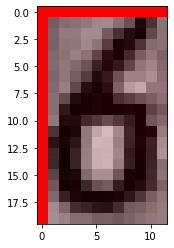

In [49]:
contours = segement_plate_contours(image)
plt.imshow(contours[1])
#plate_text = get_plate_text_V1(contours)
print(contours[1].shape)

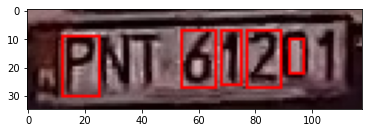

In [50]:
plt.imshow(image)